# Train and Test the Preprocessed CAPTCHA Images with ResNet-18

* Original Dataset
  * [Version 2 CAPTCHA Images (from Kaggle)](https://www.kaggle.com/fournierp/captcha-version-2-images)
    * 1070 images files of 5 letter words (200 x 50, .png or .jpg) 
      * Train: 749 images * 5 chars (70% of dataset)
        * Reduced to 3207 char images after preprocessing
      * Test: 321 images * 5 chars (30% of dataset)

* Preprocessed Dataset
  * See [image_preprocess.ipynb](image_preprocess.ipynb) to check the process and download the dataset.
  * charset = ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y'] (19 classes)
  

## 1. Load Preprocessed Images (Training Dataset)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [3]:
%pwd

'/content'

In [4]:
%ls -al

total 20
drwxr-xr-x 1 root root 4096 Jun 20 15:44 ./
drwxr-xr-x 1 root root 4096 Jun 20 14:30 ../
drwxr-xr-x 1 root root 4096 Jun 17 16:18 .config/
drwx------ 4 root root 4096 Jun 20 15:44 gdrive/
drwxr-xr-x 1 root root 4096 Jun 17 16:18 sample_data/


In [5]:
import os, shutil

train_dir = "gdrive/My Drive/Colab Notebooks/term_project/dataset/train"
dirs = os.listdir(train_dir)
total_images = 0
for d in dirs:
  path = os.path.join(train_dir, d)
  files = os.listdir(path);
  img_files = [f for f in files if f.endswith(".png") or f.endswith(".jpg")]
  img_cnt = len(img_files)
  total_images += img_cnt
  print("There are", img_cnt, "images in", os.path.join(train_dir, d))
print("## Total:", total_images, "images")

There are 142 images in gdrive/My Drive/Colab Notebooks/term_project/dataset/train/2
There are 172 images in gdrive/My Drive/Colab Notebooks/term_project/dataset/train/3
There are 174 images in gdrive/My Drive/Colab Notebooks/term_project/dataset/train/4
There are 184 images in gdrive/My Drive/Colab Notebooks/term_project/dataset/train/5
There are 174 images in gdrive/My Drive/Colab Notebooks/term_project/dataset/train/6
There are 171 images in gdrive/My Drive/Colab Notebooks/term_project/dataset/train/7
There are 171 images in gdrive/My Drive/Colab Notebooks/term_project/dataset/train/8
There are 167 images in gdrive/My Drive/Colab Notebooks/term_project/dataset/train/b
There are 177 images in gdrive/My Drive/Colab Notebooks/term_project/dataset/train/c
There are 163 images in gdrive/My Drive/Colab Notebooks/term_project/dataset/train/d
There are 158 images in gdrive/My Drive/Colab Notebooks/term_project/dataset/train/e
There are 173 images in gdrive/My Drive/Colab Notebooks/term_proj

## 2. Set Model and DataLoaders

In [6]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import models

In [6]:
model = models.resnet18(pretrained=False)
print(model.modules)

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [8]:
# Set input channel of model.conv1 as 1 (grayscale) and out_features of model.fc as 19
num_classes = 19
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)  
model.fc = nn.Linear(512, num_classes)
model.cuda()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# Set hyperparameters
num_epochs, batch_size, learning_rate = 20, 64, 0.001

In [13]:
# Transform
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.Resize((224, 224)), transforms.ToTensor()])  # (h, w)

train_dataset = ImageFolder(root='gdrive/My Drive/Colab Notebooks/term_project/dataset/train', transform=transform)
test_dataset = ImageFolder(root='gdrive/My Drive/Colab Notebooks/term_project/dataset/test', transform=transform)

# Dataloader
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size)

In [15]:
criterion = nn.CrossEntropyLoss()  #
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 3. Train the Model
  * Training accuracy: 100%

In [16]:
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()
    outputs = model(images)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    if (i + 1) % 25 == 0:
      print('Epoch: {}/{}, Batch Step: {}/{}, Loss: {:.4f}, Training Accuracy of the Current Batch: {}%'
      .format(epoch + 1, num_epochs, i+1, train_loader.__len__(), loss.item(), 100*correct / batch_size))

Epoch: 1/20, Batch Step: 25/51, Loss: 0.4465, Training Accuracy of the Current Batch: 87.5%
Epoch: 1/20, Batch Step: 50/51, Loss: 0.3070, Training Accuracy of the Current Batch: 92.1875%
Epoch: 2/20, Batch Step: 25/51, Loss: 0.2474, Training Accuracy of the Current Batch: 90.625%
Epoch: 2/20, Batch Step: 50/51, Loss: 0.2426, Training Accuracy of the Current Batch: 92.1875%
Epoch: 3/20, Batch Step: 25/51, Loss: 0.2386, Training Accuracy of the Current Batch: 92.1875%
Epoch: 3/20, Batch Step: 50/51, Loss: 0.1332, Training Accuracy of the Current Batch: 96.875%
Epoch: 4/20, Batch Step: 25/51, Loss: 0.1509, Training Accuracy of the Current Batch: 93.75%
Epoch: 4/20, Batch Step: 50/51, Loss: 0.0832, Training Accuracy of the Current Batch: 96.875%
Epoch: 5/20, Batch Step: 25/51, Loss: 0.0272, Training Accuracy of the Current Batch: 100.0%
Epoch: 5/20, Batch Step: 50/51, Loss: 0.1041, Training Accuracy of the Current Batch: 96.875%
Epoch: 6/20, Batch Step: 25/51, Loss: 0.0703, Training Accura

## 4. Save the Trained Parameters 

In [22]:
torch.save(model.state_dict(), 'gdrive/My Drive/Colab Notebooks/term_project/captcha_resnet18_channel_1.pt')

In [23]:
%ls -al gdrive/My\ Drive/Colab\ Notebooks/term_project/

total 88124
-rw------- 1 root root 44779020 Jun 20 09:25 captcha_resnet18_channel_1.pt
-rw------- 1 root root 44804320 Jun 19 16:14 captcha_resnet18.pt
drwx------ 4 root root     4096 Jun 14 13:39 dataset/
-rw------- 1 root root   227898 Jun 19 13:26 image_preprocess.ipynb
-rw------- 1 root root   421924 Jun 15 07:58 image_preprocess_tutorial.ipynb


## 5. Test the Trained Model
* Load saved parameters and evaluate the model with the test dataset
  * Test accuracy: 85.88%
  * See the confusion matrix plotted below.
* Show predicted labels of each CAPTCHA image of the test dataset

In [14]:
from PIL import Image

In [15]:
num_classes = 19
model_saved = models.resnet18(pretrained=False)
model_saved.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_saved.fc = nn.Linear(512, num_classes)
model_saved.load_state_dict(torch.load("gdrive/My Drive/Colab Notebooks/term_project/captcha_resnet18_channel_1.pt"))
model_saved.cuda()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
model_saved.eval()
with torch.no_grad():
  total, correct = 0, 0
  for images, labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    outputs = model_saved(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  print("Test Accuracy of the Test Images: {:.2f}%".format(100 * correct / total))

Test Accuracy of the Test Images: 85.88%


In [17]:
test_captcha_list = ['gfp54.png', 'nbfx5.png', 'mg5nn.png', 'n5wbg.png', 'gcx6f.png', 'neecd.png', 'g842c.png', 'm4fd8.png', 'pn7pn.png', 'gnf85.png', 'ndg2b.png', 'nfg23.png', 'm2nf4.png', 'g6n7x.png', 'gymmn.png', 'm448b.png', 'mm3nn.png', 'mfb3x.png', 'ndecc.png', 'n2c85.jpg', 'gcfgp.png', 'gewfy.png', 'mcyfx.png', 'pwmbn.png', 'm8m4x.png', 'geyn5.jpg', 'pp546.png', 'gxxpf.png', 'gnbde.png', 'm2576.png', 'pgmn2.png', 'pybee.png', 'gpnxn.png', 'n7ebx.png', 'p8ngx.png', 'pg4bf.png', 'p57fn.png', 'gn2xy.png', 'p5g5m.png', 'mfc35.png', 'n2gmg.png', 'p6mn8.png', 'gpxng.png', 'nxc83.png', 'nbcgb.png', 'gm7n8.png', 'pe4xn.png', 'mmy5n.png', 'm3588.png', 'gnbn4.png', 'pg2pm.png', 'ne325.png', 'ny3nn.png', 'mpmy5.png', 'mxnw4.png', 'pxdwp.png', 'mc8w2.png', 'mpxfb.png', 'mnef5.png', 'n3ffn.png', 'n3x4c.png', 'p8c24.png', 'g8gnd.png', 'p24gn.png', 'gny6b.png', 'm5ym2.png', 'n5x2n.png', 'gw468.png', 'ng6yp.png', 'n336e.png', 'ncw4g.png', 'ncyx8.png', 'mgw3n.png', 'm6n4x.png', 'pym7p.png', 'p4pde.png', 'g888x.png', 'neggn.png', 'pw5nc.png', 'n6xc5.png', 'g7fmc.png', 'gf2g4.png', 'n2by7.png', 'pcmcc.jpg', 'nxf2c.jpg', 'mggce.png', 'm8gmx.png', 'nbp3e.png', 'ndme7.png', 'n464c.png', 'nb267.png', 'gegw4.png', 'g78gn.png', 'gy5bf.png', 'pwebm.png', 'ng46m.png', 'n373n.png', 'nm248.png', 'n7meb.png', 'p2m6n.png', 'nbwpn.png', 'n8fp6.png', 'mgdwb.png', 'x74b2.png', 'yf28d.png', 'yemy4.png', 'xngxc.png', 'wc2bd.png', 'xfn6n.png', 'xfg65.png', 'xe6eb.png', 'y48c3.png', 'ypp8f.png', 'wd2gb.png', 'xnnc3.png', 'xbcbx.png', 'yge7c.jpg', 'y5w28.png', 'y7x8p.png', 'xxney.png', 'y4g3b.png', 'yew6p.png', 'yeyn4.png', 'ymp7g.png', 'w2e87.png', 'xgcxy.png', 'y2ye8.png', 'wbncw.png', 'y5n6d.png', 'yd38e.png', 'ygenn.png', 'xe8xm.png', 'ypw3d.png', 'w48cw.png', 'w6yne.png', 'xyncc.png', 'x5f54.png', 'wm746.png', 'ywn6f.png', 'wddcp.png', 'xnd3y.png', 'ycmcw.png', 'wfy5m.png', 'w52fn.png', 'w2yp7.png', 'yw7ny.png', 'x2cnn.png', 'w6pxy.png', 'y33nm.png', 'wxcn8.png', 'w2n7e.png', 'xnn4d.png', 'ydg8n.png', 'yd3m3.png', 'y5dpp.png', 'x3deb.png', 'yy824.png', 'x4pnp.png', 'y2xg4.png', 'xmcym.png', 'xxw44.png', 'xymfn.png', 'xxbm5.png', 'x775w.png', 'w75w8.png', 'x38fn.png', 'wf684.png', 'y4ec2.png', 'wye85.png', 'ycnfc.png', 'y866y.png', 'wnpec.png', 'y2436.png', 'yxd7m.png', 'x7422.png', 'wwmn6.png', 'x7547.png', 'yf347.png', 'x76mn.png', 'yyg5g.png', 'x44n4.png', 'w4nfx.png', 'wdww8.png', 'x347n.png', 'w4cnn.png', 'w8f36.png', 'xw465.png', 'x362g.png', 'wyc25.png', 'x277e.png', 'wecfd.png', 'xemyg.png', 'y32yy.png', 'w8bnx.png', 'w6ny4.jpg', 'xdn65.png', 'wb3ed.png', 'xbem6.png', 'x8e8n.png', 'w4cdc.png', 'xcmbp.png', 'x7746.png', 'xcf88.png', 'xdcn4.png', 'xf5g7.png', 'xnfx5.png', 'y53c2.png', 'x37bf.png', 'x6pdb.png', 'yd755.png', 'yyn57.png', 'xp24p.png', 'yf424.png', 'yx2d4.png', 'yfdn7.png', 'wgnwp.png', 'xce8d.png', 'x8xnp.png', 'x4f7g.png', 'ygfwe.png', 'wmpmp.png', 'x3fwf.png', 'y3c58.png', 'yw8y5.jpg', 'wce5n.png', 'xyyyw.png', 'yg5bb.png', 'ydd3g.png', 'yw667.png', 'y5g87.png', 'ybfx6.png', 'w4x2m.png', 'y7mnm.png', 'y7d75.png', 'xc68n.png', 'y4n6m.png', 'x458w.png', 'x5nyn.png', 'wm47f.png', 'ygce8.jpg', 'x4gg5.png', 'x6b5m.png', 'wg625.png', 'w7e6m.png', 'wnmyn.png', 'xwx7d.png', 'xf4p4.png', 'wxy4n.png', 'xfgxb.png', 'w46ep.png', '23n88.png', '2g783.png', '253dc.png', '2cg58.png', '2356g.png', '25w53.png', '28348.png', '22d5n.png', '23mdg.png', '28x47.png', '25egp.png', '25p2m.png', '2cgyx.png', '2cegf.png', '2n73f.png', '2enf4.png', '268g2.png', '244e2.png', '245y5.png', '24pew.png', '264m5.png', '2fxgd.png', '25257.png', '226md.png', '2gyb6.png', '25m6p.png', '2g7nm.png', '2bg48.png', '2mpnn.png', '24f6w.png', '2en7g.png', '243mm.png', '2mg87.png', '2b827.png', '33p4e.png', '377xx.png', '3dgmf.png', '2p2y8.png', '3p4nn.png', '3mxdn.png', '32dnn.png', '33f7m.png', '3cpwb.png', '2wc38.png', '44c22.png', '34b84.png', '42dw4.png', '33n73.png', '2yggg.png', '43xfe.png', '3ye2e.png', '3n3cf.png', '43p5d.png', '37ep6.png', '3d7bd.png', '3x5fm.png', '3pe4g.png', '387g2.png', '2ycn8.png', '2nf26.png', '3b4we.png', '36w25.png', '33b22.png', '445cc.png', '34fxm.png', '2xc2n.png', '34pcn.png', '378e5.png', '38n57.png', '2nx38.png', '3bnyf.png']
# index of each char -> class number
charset = ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']

In [19]:
model_saved.eval()
with torch.no_grad():
  for captcha in test_captcha_list:
    answer = captcha[:5]
    predicted = ''
    correct = 0
    acc = 0
    for c in answer:
      c_img_path = os.path.join('gdrive/My Drive/Colab Notebooks/term_project/dataset/test', c, answer+'_'+c+captcha[-4:])
      #print("Load", c_img_path)
      c_img = Image.open(c_img_path).convert('L')
      c_img = transform(c_img)
      c_img = c_img.unsqueeze(0)
      c_img = c_img.cuda()
      label = charset.index(c)

      output = model_saved(c_img)
      _, index = torch.max(output, 1)

      correct += (index == label).sum().item()
      
      predicted += charset[index[0]]
      acc = 100 * correct / 5
    
    print("answer: {}, predicted: {}, percentage of chars correct: {}%".format(answer, predicted, acc))

answer: gfp54, predicted: gfp54, percentage of chars correct: 100.0%
answer: nbfx5, predicted: mbfx5, percentage of chars correct: 80.0%
answer: mg5nn, predicted: mg5nn, percentage of chars correct: 100.0%
answer: n5wbg, predicted: n5wbg, percentage of chars correct: 100.0%
answer: gcx6f, predicted: gcx6f, percentage of chars correct: 100.0%
answer: neecd, predicted: neecd, percentage of chars correct: 100.0%
answer: g842c, predicted: g842c, percentage of chars correct: 100.0%
answer: m4fd8, predicted: m4fd8, percentage of chars correct: 100.0%
answer: pn7pn, predicted: pn7pn, percentage of chars correct: 100.0%
answer: gnf85, predicted: gnf85, percentage of chars correct: 100.0%
answer: ndg2b, predicted: mdg2b, percentage of chars correct: 80.0%
answer: nfg23, predicted: nfg23, percentage of chars correct: 100.0%
answer: m2nf4, predicted: m22nf, percentage of chars correct: 40.0%
answer: g6n7x, predicted: g6n7x, percentage of chars correct: 100.0%
answer: gymmn, predicted: gymmm, perc

In [20]:
# Plot confusion matrix
# Code from https://stackoverflow.com/questions/53290306/confusion-matrix-and-test-accuracy-for-pytorch-transfer-learning-tutorial

confusion_matrix = torch.zeros(num_classes, num_classes)

with torch.no_grad():
  for i, (images, labels) in enumerate(test_loader):
    images = images.cuda()
    labels = labels.cuda()
    outputs = model_saved(images)
    _, predicted = torch.max(outputs.data, 1)
    for t, p in zip(labels.view(-1), predicted.view(-1)):
      confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[ 86.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   2.,   0.,   0.,   0.,
           0.,   0.,   3.,   0.,   1.,   2.,   0.],
        [  0.,  72.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  1.,   0.,  74.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,
           0.,   0.,   2.,   0.,   2.,   0.,   4.],
        [  2.,   1.,   0.,  63.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,
           0.,   0.,   1.,   0.,   0.,   1.,   1.],
        [  0.,   0.,   3.,   0.,  45.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,
           0.,   4.,   0.,   0.,   1.,   0.,   1.],
        [  0.,   0.,   1.,   1.,   1.,  55.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   1.,   1.,   1.,   0.,   1.,   0.],
        [  0.,   0.,   2.,   1.,   2.,   0.,  61.,   0.,   1.,   0.,   0.,   0.,
           0.,   0.,   1.,   0.,   1.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  47.,   0.,   0., 

In [21]:
# Accuracy per class
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([0.8958, 0.9730, 0.8706, 0.8873, 0.8036, 0.8871, 0.8841, 0.9400, 0.7692,
        0.6327, 0.9016, 0.8462, 0.9885, 0.5949, 0.7955, 0.8594, 0.8831, 0.8932,
        0.9462])


In [22]:
# Plot confusion matrix by plt
# Code from https://deeplizard.com/learn/video/0LhiS6yu2qQ

import itertools
import numpy as np

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.figure(figsize=(10,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.89583333 0.         0.         0.01041667 0.         0.01041667
  0.         0.         0.02083333 0.         0.         0.
  0.         0.         0.03125    0.         0.01041667 0.02083333
  0.        ]
 [0.         0.97297297 0.         0.         0.         0.
  0.         0.         0.02702703 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.01176471 0.         0.87058824 0.         0.         0.01176471
  0.         0.         0.         0.         0.         0.01176471
  0.         0.         0.02352941 0.         0.02352941 0.
  0.04705882]
 [0.02816901 0.01408451 0.         0.88732394 0.         0.01408451
  0.         0.         0.         0.         0.01408451 0.
  0.         0.         0.01408451 0.         0.         0.01408451
  0.01408451]
 [0.         0.         0.05357143 0.         0.80357143 0.01785714
  0.         0.         0.         0.         0.01785714 0.
  0.         0.07142

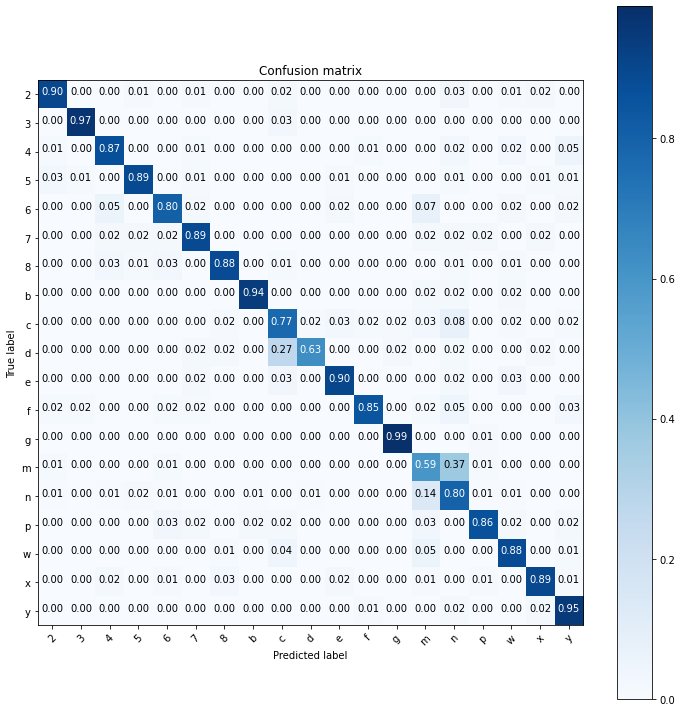

In [23]:
plot_confusion_matrix(confusion_matrix.numpy(), train_dataset.classes, normalize=True)